# Constuct CPDAG from Simulate Data Using PC Algorithm

Author: Fengzhi Li

Date: 05/30/2021

In [ ]:
# For Colab
!git clone https://github.com/L-F-Z/PCdemo/
!mv ./PCdemo/*.py ./

In [1]:
import numpy as np
import networkx as nx
from dataset import bin_data, dis_data
from ci_tests import ci_test_bin, ci_test_dis
from itertools import combinations, permutations

 ## Estimate a skeleton graph from the statistis information.
 
 Args:
    - indep_test_func: the function for a conditional independency test.
    - data_matrix: data (as a numpy array).
    - alpha: the significance level.
    
 Returns:
    - g: a skeleton graph (as a networkx.Graph).
    - sep_set: a separation set (as an 2D-array of set()).

In [2]:
def estimate_skeleton(indep_test_func, data_matrix, alpha, **kwargs):
    node_ids = range(data_matrix.shape[1])
    node_size = data_matrix.shape[1]
    sep_set = [[set() for i in range(node_size)] for j in range(node_size)]
    # Create a complete graph from the list of node ids.
    g = nx.Graph()
    g.add_nodes_from(node_ids)
    for (i, j) in combinations(node_ids, 2):
        g.add_edge(i, j)

    l = 0
    while True:
        cont = False
        for (i, j) in permutations(node_ids, 2):
            adj_i = list(g.neighbors(i))
            if j not in adj_i:
                continue
            else:
                adj_i.remove(j)
            if len(adj_i) >= l:
                for k in combinations(adj_i, l):
                    p_val = indep_test_func(data_matrix, i, j, set(k), **kwargs)
                    if p_val > alpha:
                        if g.has_edge(i, j):
                            g.remove_edge(i, j)
                        sep_set[i][j] |= set(k)
                        sep_set[j][i] |= set(k)
                        break
                cont = True
        l += 1
        if cont is False:
            break
    return (g, sep_set)

## Estimate a CPDAG from the skeleton graph and separation sets

Args:
    - skel_graph: A skeleton graph (an undirected networkx.Graph).
    - sep_set: a separation set (as an 2D-array of set()).

Returns:
    - An estimated CPDAG.

### Rule 1
Orient $a−b$ into $a \rightarrow b$ whenever there is an arrow $c \rightarrow a$ such that $c$ and $b$ are nonadjacent.

In [3]:
def rule1(dag, a, b):
    # Look all the predecessors of a
    for c in dag.predecessors(a):
        # Skip if there is an arrow a->c
        if dag.has_edge(a, c): 
            continue
        # Skip if c and b are adjacent
        if dag.has_edge(c, b) or dag.has_edge(b, c):
            continue
        # Make a-b into a->b
        dag.remove_edge(b, a)
        return False
    return True

### Rule 2
Orient $a-b$ into $a \rightarrow b$ whenever there is chain $a \rightarrow c \rightarrow b$.

In [4]:
def rule2(dag, a, b):
    # Find nodes c where k is a->c.
    succs_a = set() 
    for c in dag.successors(a):
        if not dag.has_edge(c, a):
            succs_a.add(c)
    # Find nodes b where b is c->b.
    preds_b = set()
    for c in dag.predecessors(b):
        if not dag.has_edge(b, c):
            preds_b.add(c)
    # Check if there is any node k where a->c->b.
    if len(succs_a & preds_b) > 0:
        # Make a-b into a->b
        dag.remove_edge(b, a)
        return False
    return True

### Rule 3
Orient $a-b$ into $a \rightarrow b$ whenever there are two chains $a-c \rightarrow b$ and $a-d \rightarrow b$ such that $c$ and $d$ are nonadjacent.

In [5]:
def rule3(dag, a, b):
    # Find nodes k where a-c.
    adj_a = set()
    for c in dag.successors(a):
        if dag.has_edge(c, a):
            adj_a.add(c)
    # For all the pairs of nodes in adj_a,
    for (c, d) in combinations(adj_a, 2):
        # Skip if c and d are adjacent.
        if dag.has_edge(c, d) or dag.has_edge(d, c):
            continue
        # Skip if not c->b.
        if dag.has_edge(b, c) or (not dag.has_edge(c, b)):
            continue
        # Skip if not d->b.
        if dag.has_edge(b, d) or (not dag.has_edge(d, b)):
            continue
        # Make a-b into a->b.
        dag.remove_edge(b, a)
        return False
    return True

### Estimate CPDAG using Rule1-3

In [6]:
def estimate_cpdag(skel_graph, sep_set):
    dag = skel_graph.to_directed()
    node_ids = skel_graph.nodes()
    for (i, j) in combinations(node_ids, 2):
        adj_i = set(dag.successors(i))
        if j in adj_i:
            continue
        adj_j = set(dag.successors(j))
        if i in adj_j:
            continue
        if sep_set[i][j] is None:
            continue
        common_k = adj_i & adj_j
        for k in common_k:
            if k not in sep_set[i][j]:
                if dag.has_edge(k, i):
                    dag.remove_edge(k, i)
                if dag.has_edge(k, j):
                    dag.remove_edge(k, j)

    # For all the combination of nodes i and j, apply the following rules.
    old_dag = dag.copy()
    while True:
        for (i, j) in combinations(node_ids, 2):
            # Check if i-j.
            chk = dag.has_edge(i, j) and dag.has_edge(j, i)
            if chk: chk = rule1(dag, i, j)
            if chk: chk = rule2(dag, i, j)
            if chk: chk = rule3(dag, i, j)
        if nx.is_isomorphic(dag, old_dag):
            break
        old_dag = dag.copy()
    return dag

## Demo Tests

In [7]:
draw_options = {
    "arrowsize": 30,
    "font_size": 30,
    "node_size": 2500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
    "with_labels": True,
}

### Test on Graphical Model 5-Dim Binary Example Data
This data set contains a matrix containing information on five binary variables (coded as 0/1) and the corresonding DAG model. The data was generated using Tetrad in the following way. A random DAG on five nodes was generated; binary variables were assigned to each node; then conditional probability tables corresponding to the structure of the generated DAG were constructed. Finally, 5000 samples were drawn using the conditional probability tables.

[[0 0 1 0 1]
 [1 0 0 0 0]
 [1 1 1 0 1]
 [0 0 0 0 0]
 [0 1 0 0 1]]


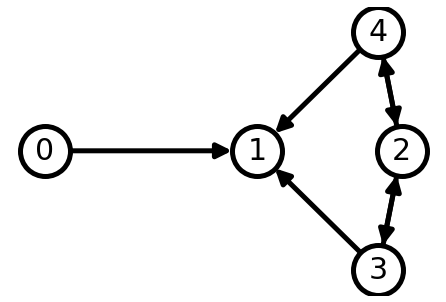

In [8]:
g_answer = nx.DiGraph()
g_answer.add_nodes_from([0, 1, 2, 3, 4])
g_answer.add_edges_from([(0, 1), (2, 3), (3, 2), (3, 1), (2, 4), (4, 2), (4, 1)])
nx.draw_spectral(g_answer, **draw_options)
dm = np.array(bin_data).reshape((5000, 5))
print(dm[0:5])

True


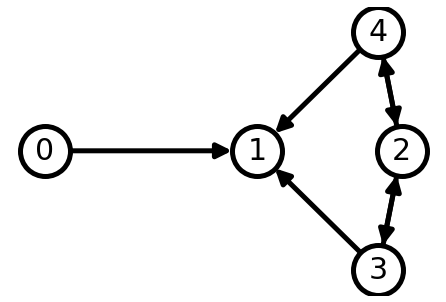

In [9]:
(g, sep_set) = estimate_skeleton(indep_test_func=ci_test_bin,
                                 data_matrix=dm,
                                 alpha=0.01)
g = estimate_cpdag(skel_graph=g, sep_set=sep_set)
print(nx.is_isomorphic(g, g_answer))
nx.draw_spectral(g, **draw_options)

### Test on Graphical Model Discrete 5-Dim Example Data
This data set contains a matrix containing information on five discrete variables (levels are coded as numbers) and the corresonding DAG model. The data was generated using Tetrad in the following way. A random DAG on five nodes was generated; discrete variables were assigned to each node (with 3, 2, 3, 4 and 2 levels); then conditional probability tables corresponding to the structure of the generated DAG were constructed. Finally, 10000 samples were drawn using the conditional probability tables.

[[2 0 0 2 1]
 [2 1 1 2 1]
 [1 0 1 3 0]
 [1 0 2 2 1]
 [1 0 0 2 1]]


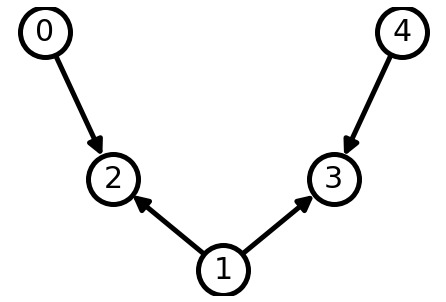

In [10]:
g_answer = nx.DiGraph()
g_answer.add_nodes_from([0, 1, 2, 3, 4])
g_answer.add_edges_from([(0, 2), (1, 2), (1, 3), (4, 3)])
nx.draw_spectral(g_answer, **draw_options)
dm = np.array(dis_data).reshape((10000, 5))
print(dm[0:5])

True


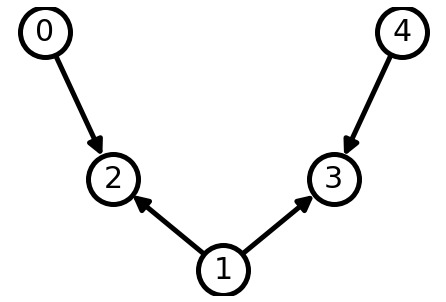

In [11]:
(g, sep_set) = estimate_skeleton(indep_test_func=ci_test_dis,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 levels=[3,2,3,4,2])
g = estimate_cpdag(skel_graph=g, sep_set=sep_set)
print(nx.is_isomorphic(g, g_answer))
nx.draw_spectral(g, **draw_options)